# Reflexer: Verification Model & Simulation

In [1]:
import matplotlib.pyplot as plt
from FixedPoint import FXnum
from decimal import Decimal
import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.plotting.backend = "plotly"

import sys
sys.path.append('./models')

from models.run import run
import models.options as options

## Load External Data Source

In [5]:
from models.utils.load_data import debt_price_data

debt_price_source = options.DebtPriceSource.DEBT_MARKET_MODEL.value
debt_price_data = debt_price_data(debt_price_source)

/Users/bscholtz/workspace/reflexer/venv/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [6]:
debt_price_data

[     seconds_passed         0  debt_price  price_move
 0             86400  1.009150    1.009150    0.009150
 1             86400  1.009032    1.009032   -0.000117
 2             86400  1.009064    1.009064    0.000031
 3             86400  1.009471    1.009471    0.000407
 4             86400  1.009220    1.009220   -0.000250
 ..              ...       ...         ...         ...
 647           86400  1.008924    1.008924   -0.000105
 648           86400  1.010181    1.010181    0.001257
 649           86400  1.009824    1.009824   -0.000357
 650           86400  1.011400    1.011400    0.001576
 651           86400  1.012062    1.012062    0.000662
 
 [652 rows x 4 columns]]

# Simulation Configuration

Set the simulation timesteps to the minimum dataset length:

In [7]:
minimum_timesteps = min([df.shape[0] for df in debt_price_data])
SIMULATION_TIMESTEPS = range(minimum_timesteps)
SIMULATION_TIMESTEPS

range(0, 652)

Override certain parameter sweeps with the generated sets, using ConfigWrapper for convenience:

In [8]:
from cadCAD.configuration import Experiment
from models.config_wrapper import ConfigWrapper
import models.options

import models.market_model as market_model

In [9]:
# Update parameter options
update_params = {
    # By using an Enum, we can self-document all possible options
    options.DebtPriceSource.__name__: [debt_price_source],
    options.IntegralType.__name__: [options.IntegralType.LEAKY.value],
    'controller_enabled': [False, True],
    # Generate a lambda for each test dataframe, that returns a row value at a specific timestep
    'seconds_passed': [
        lambda timestep, df=df.copy(): int(df.iloc[timestep - 1]['seconds_passed'])
        for df in debt_price_data
    ],
    'price_move': [
        lambda timestep, df=df.copy(): float(df.iloc[timestep - 1]['price_move'])
        for df in debt_price_data
    ],
    # Select or sweep the error term calculation, as a lambda
    # e.g. p*-p vs (p*-p)/p vs (p*-p)/p*
    'error_term': [
        lambda target, measured: target - measured,
        #lambda target, measured: (target - measured) / measured,
        #lambda target, measured: (target - measured) / target
    ]
}

'''
The ConfigWrapper allows you to pass a model as an argument, and update the simulation configuration.
Maps (params, states) would be merge updated, and all other options are overrides.
'''
market_simulation = ConfigWrapper(market_model, M=update_params, T=SIMULATION_TIMESTEPS)

# Simulation Execution

In [10]:
from cadCAD import configs
del configs[:]

market_simulation.append()

(data, tensor_field, sessions) = run(drop_midsteps=True)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (652, 22, 2, 15)
Execution Method: local_simulations
SimIDs   : [0, 0]
SubsetIDs: [0, 1]
Ns       : [0, 1]
ExpIDs   : [0, 0]
Execution Mode: parallelized
Total execution time: 0.93s


# Data Preparation

In [11]:
df = data.copy()
df

,index,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,...,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0,2018-12-18,0,0,0,1,0,0
1,6,0.002300,0.011450,0.0,0.0,0.0,494.621341,2.662037e-08,2.662037e-08,0.000000e+00,...,0.997700,1.009150,86400,2018-12-19,5760,0,0,1,6,1
2,12,-0.003328,0.005704,0.0,0.0,0.0,1235.657124,-6.514399e-08,-6.514399e-08,0.000000e+00,...,1.003328,1.009032,86400,2018-12-20,11520,0,0,1,6,2
3,18,-0.006482,0.002581,0.0,0.0,0.0,1593.592281,-3.650415e-08,-3.650415e-08,0.000000e+00,...,1.006482,1.009064,86400,2018-12-21,17280,0,0,1,6,3
4,24,-0.009439,0.000032,0.0,0.0,0.0,1706.477892,-3.422170e-08,-3.422170e-08,0.000000e+00,...,1.009439,1.009471,86400,2018-12-22,23040,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,7801,-0.001420,0.000190,0.0,0.0,0.0,4649.421525,-1.826286e-08,-1.826286e-08,9.857379e-09,...,1.008734,1.008924,86400,2020-09-26,3732480,0,1,1,6,648
1302,7807,-0.001668,0.000341,0.0,0.0,0.0,4672.367583,-2.874450e-09,-2.874450e-09,1.158194e-08,...,1.009840,1.010181,86400,2020-09-27,3738240,0,1,1,6,649
1303,7813,-0.002034,-0.001391,0.0,0.0,0.0,4626.989698,-4.234317e-09,-4.234317e-09,1.412237e-08,...,1.011215,1.009824,86400,2020-09-28,3744000,0,1,1,6,650
1304,7819,-0.000842,0.000144,0.0,0.0,0.0,4573.092377,1.378798e-08,1.378798e-08,5.850106e-09,...,1.011256,1.011400,86400,2020-09-29,3749760,0,1,1,6,651


In [12]:
df['target_rate_seconds'] = df.target_rate # * 3600
df['error_star_derivative_scaled'] = df.error_star_derivative * 3600
df['error_hat_derivative_scaled'] = df.error_star_derivative * 3600

# Data Analysis

In [13]:
import plotly.express as px

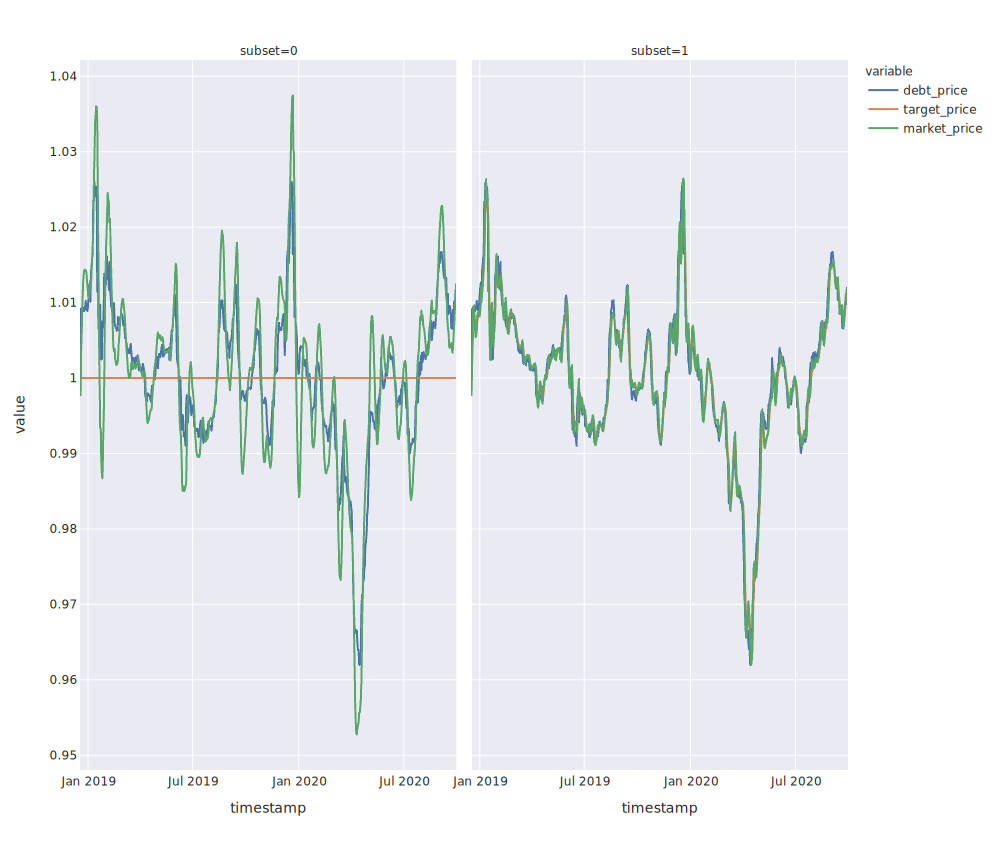

In [14]:
fig = px.line(
    df,
    x='timestamp',
    y=['debt_price', 'target_price', 'market_price'],
    facet_col='subset',
    facet_col_wrap=4,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/controller-target-plot.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/controller-target-plot.svg'))

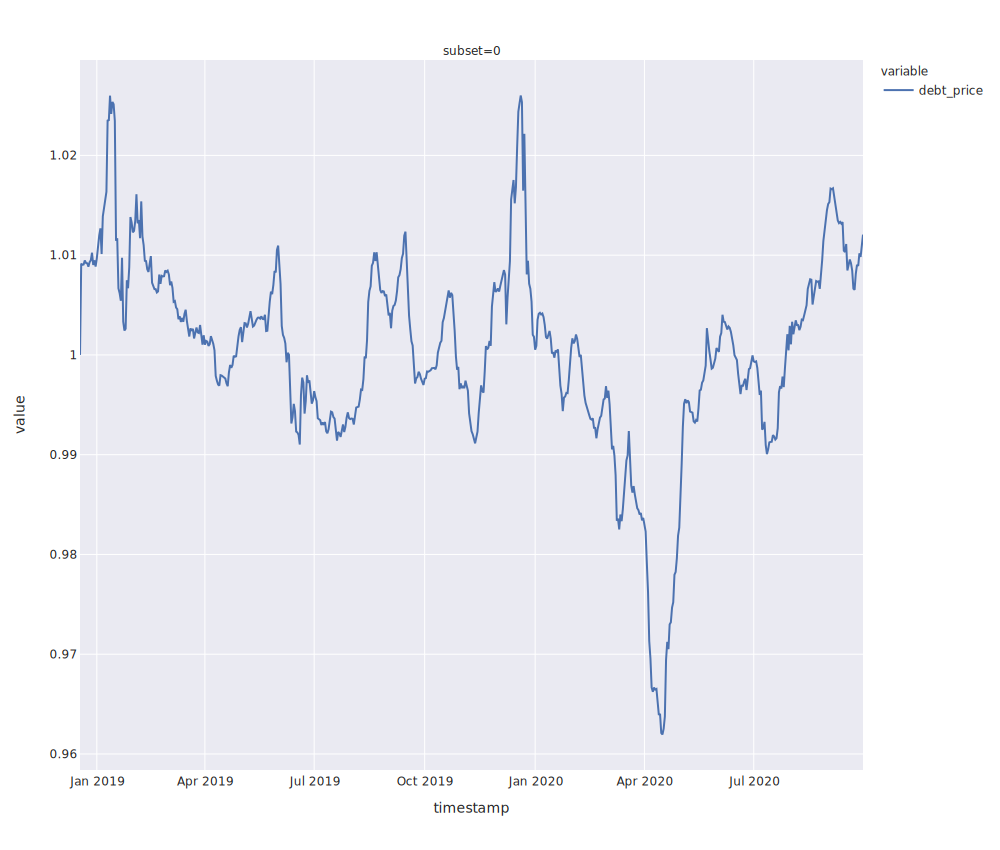

In [15]:
fig = px.line(
    df[df.subset == 0],
    x='timestamp',
    y=['debt_price'],
    facet_col='subset',
    facet_col_wrap=5,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/debt-price-plot.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/debt-price-plot.svg'))

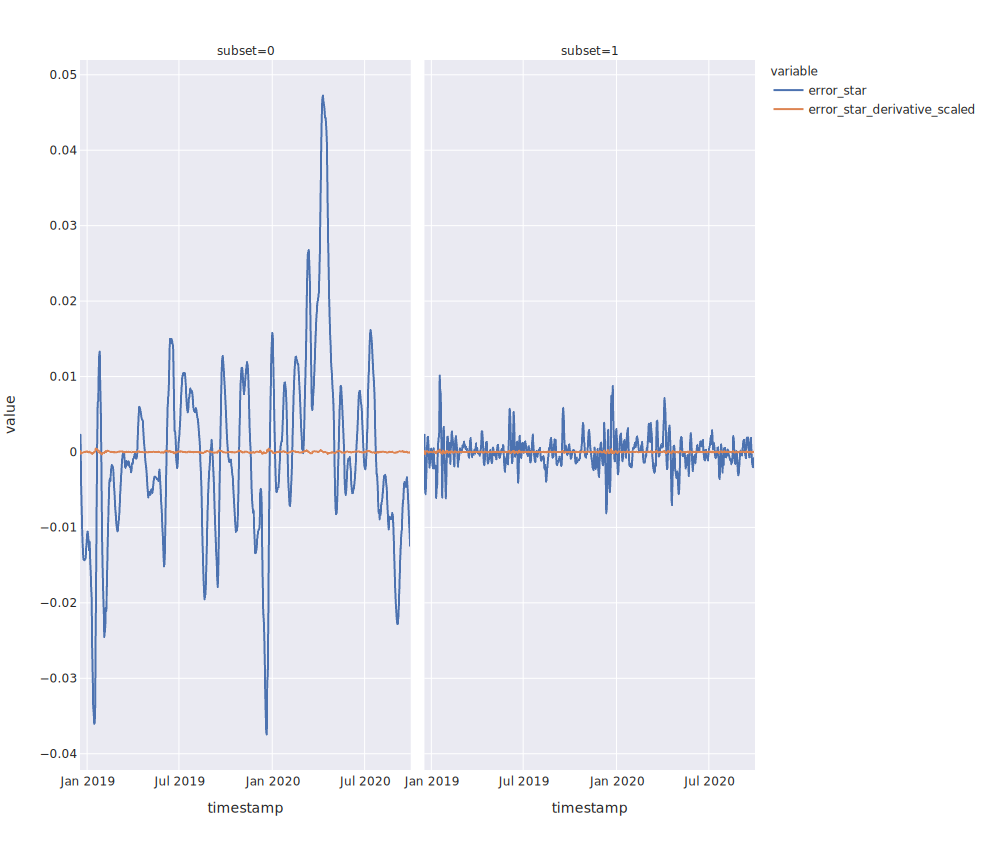

In [16]:
fig = px.line(
    df,
    x='timestamp',
    y=['error_star','error_star_derivative_scaled'],
    facet_col='subset',
    facet_col_wrap=4,
    template='seaborn',
    height=800
)

# fig.show()
fig.write_image('plots/error-star-plot.svg', width=1000, height=850)
from IPython.display import SVG,display
display(SVG(filename='plots/error-star-plot.svg'))

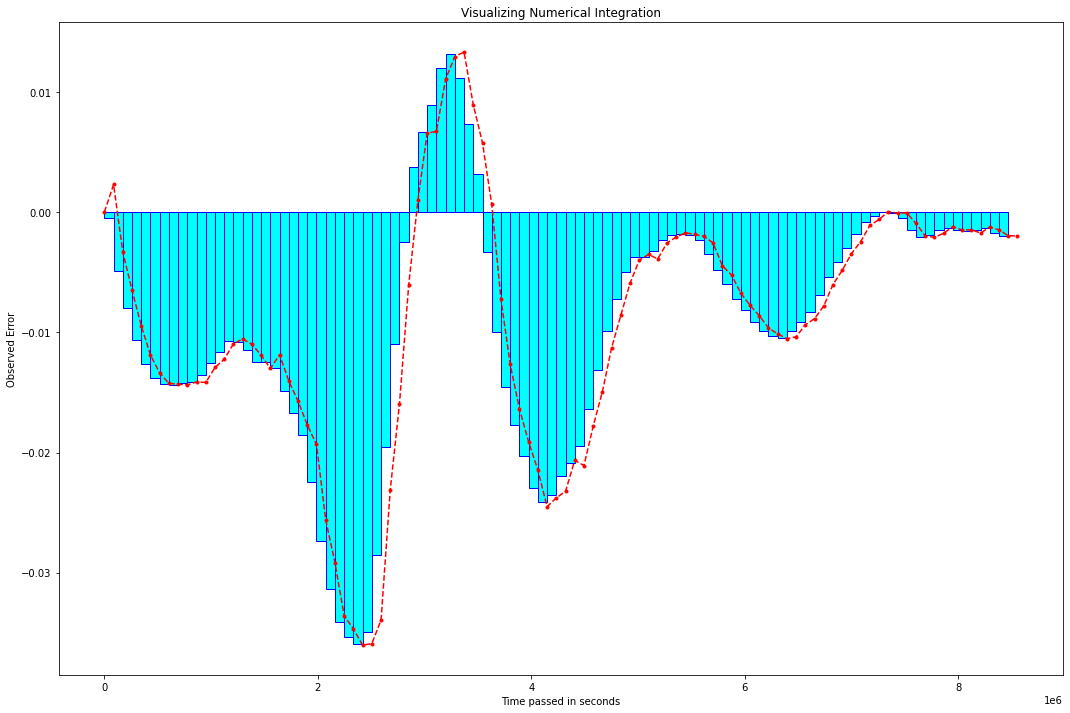

In [17]:
from utils.plots import integral_plot

integral_plot(df[(df.timestep < 100)])